

Goal: need to be able to measure delta time of two identical but time delayed signals to within 3e-8 seconds

In [77]:
freq = 123.456

In [73]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [89]:
import sys
!{sys.executable} -m pip install samplerate

In [90]:
import samplerate

In [78]:
transmitTime = 0.020

In [79]:
goal = 3 * (10 ** (-8))

In [188]:
sampleRate = 2 * (10 ** 5)

In [189]:
c = 3 * (10 ** 7)

Assuming two perfectly synchronized receivers $(R_1, R_2)$, located at $(x_1, y_1)$ and $(x_2, y_2)$ 

In [82]:
# Ground truth transmitter location to be fixed, I have not yet calculated target location based on time offsets set below 
# (or I could calculate expected offsets based on location difference)
x_target = 0
y_target = 0

x_1 = 0
x_2 = 0

y_1 = 25
y_2 = -50

In [190]:
def produceExampleSignal(sampleRate, offsetTime, transmitTime, freq, amp ):
    duration = offsetTime + transmitTime
    num_tot_samples = sampleRate * duration
    num_samples = sampleRate * transmitTime
    t = np.arange(num_samples) / sampleRate
    t_tot = np.arange(num_tot_samples) / sampleRate
    x = amp * np.sin(2 * np.pi * (freq * t - phase)) 
    new = np.zeros(int(sampleRate * offsetTime))
    x = np.concatenate((new, np.array(x)))
    return x, t_tot

Assume $R_1$ is used as a reference sensor

In [191]:
#sample sinusoid with offset
#these represent absolute offsets from the start of recording time of Receiver 1

offset_1 = .005
offset_2 = .010

#sample for 50ms, while signal is transitted for 20ms, assume sinusoid is centered at 0
amp = 1
phase = 0

x_1, t_1 = produceExampleSignal(sampleRate, offset_1, transmitTime, freq, amp)

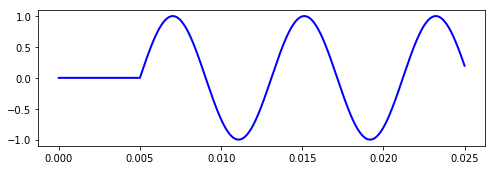

In [192]:
plt.figure(figsize=(8, 2.5))
plt.plot(t_1, x_1, color='blue', linewidth=2.0, linestyle='-')

In [193]:
x_2, t_2 = produceExampleSignal(sampleRate, offset_2, transmitTime, freq, 1.5)

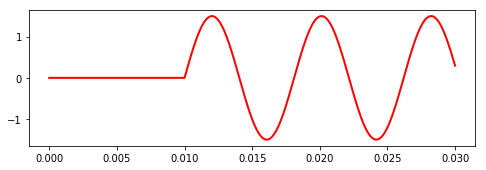

In [194]:
plt.figure(figsize=(8, 2.5))
plt.plot(t_2, x_2, color='red', linewidth=2.0, linestyle='-')

#### The following alignment process is a simple case following methods details here: https://blog.endaq.com/synchronizing-signals

In [195]:
#resample both signals to 3*10^8 sampling rate
#Due to memory issues, I brought sampling rate down to 2*10^4, and goal down to 3*10^7 in order
#to keep ratio between the two at 150
res_x_1 = samplerate.resample(x_1, 150, 'linear')
res_t_1 = samplerate.resample(t_1, 150, 'linear')
res_x_2 = samplerate.resample(x_2, 150, 'linear')
res_t_2 = samplerate.resample(t_2, 150, 'linear')

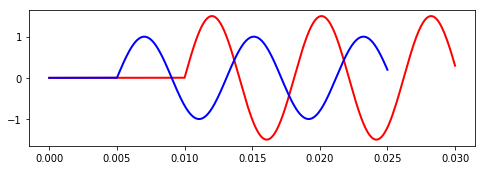

In [196]:
plt.figure(figsize=(8, 2.5))
plt.plot(res_t_2, res_x_2, color='red', linewidth=2.0, linestyle='-')
plt.plot(res_t_1, res_x_1, color='blue', linewidth=2.0, linestyle='-')

In [197]:
x_1_peaks, x_1_properties = sig.find_peaks(res_x_1)
x_2_peaks, x_2_properties = sig.find_peaks(res_x_2)

In [198]:
x_1_troughs, x_1_properties = sig.find_peaks(-res_x_1)
x_2_troughs, x_2_properties = sig.find_peaks(-res_x_2)

In [199]:
x_1_troughs

array([332400, 575400], dtype=int64)

In [200]:
# Find Points of interest and average distance between points
avg = 0
for i in range(len(x_1_peaks)):
    diff = x_1_peaks[i] - x_2_peaks[i]
    avg += diff
    print(diff)
for i in range(len(x_1_troughs)):
    diff = x_1_troughs[i] - x_2_troughs[i]
    avg += diff
    print(diff)
avg = avg / (len(x_1_peaks)+len(x_1_troughs))
print('\nFinal Average:')
print(avg)

-150000
-150000
-150000
-150000
-150000

Final Average:
-150000.0


In [174]:
#align signals using average difference between points of interest
def alignSignals(sig1, sig2, offset):
    newSig1 = sig1
    newSig2 = sig2
    if offset < 0:
        newSig2 = sig2[-offset::]
    if offset > 0:
        newSig1 = sig1[-offset::]   
    return newSig1, newSig2

In [201]:
aligned_1, aligned_2 = alignSignals(res_x_1, res_x_2, int(avg))

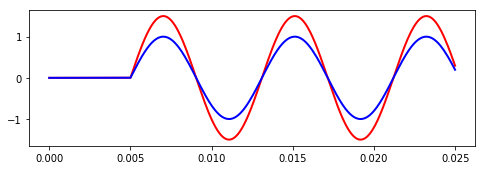

In [202]:
plt.figure(figsize=(8, 2.5))
plt.plot(res_t_1, aligned_2, color='red', linewidth=2.0, linestyle='-')
plt.plot(res_t_1, aligned_1, color='blue', linewidth=2.0, linestyle='-')

Factors currently unaccounted for in simple case:

- noise
- differences in actual sampling rate
- differences in received transmitter frequency
- differences in received signal transmission length?
- actual sampling rate and goal not used because of memory limitations(displaying resampled data was too much for my laptop)
- In a lot of my functions I assumed receiver 1 would receive the signal first